# Pulse Shaping

* **Pulse shaping** converts a sequence of discrete-time symbols into an analog signals.
  + Recall that the symbols $s_n$ are produced by the modulation mapper from a sequence of bits
  + For passband signals, the symbols may be complex-valued
* **Goals:**
  + Demonstrate how pulse-shaping is performed
  + In practice, pulse shaping is performed in discrete-time (using DSP)
  + Description of pulse shaping is usually in continuous-time
    - we address the subtleties that arise when converting between discrete and continuous time
* **Steps:**
  + Example pulses: rectangular and half-sine pulses
  + Normalize pulses to unit energy
    - in continuous and discrete time
  + performing pulse-shaping (in discrete-time)
  + Putting it all together: from a string to a signal

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

In [2]:
## import functions from the `comms` modules
# see imported modules for details for details
from comms.sources import string_source
from comms.mod_mapping import PAM4, mod_mapper

## Pulses for Pulse Shaping

* The purpose of pulse-shaping is to convert the discrete-time sequence of symbols $s_n$ to an analog, continuous-time signal $s(t)$.
  - the symbols and, thus, the signal may be complex-valued
* For linear, digital modulation, the relationship between symbols $s_n$ and the signal $s(t)$ is given by
$$
s(t) = \sum_n s_n \cdot p(t-nT),
$$
  + where $p(t)$ is a pulse signal and $T$ is the symbol duration.
  + we will assume (initially) that $p(t)$ is of duration $T$, i.e., $p(t)=0$ for $t<0$ and for $t \geq T$.
* Examples of pulses are:
  - rectangular pulse:
  $$
   p(t) = \begin{cases}
   \frac{1}{\sqrt{T}} & \text{for $0 \leq t < T$ }\\
   0 & \text{else.}
   \end{cases}
  $$
  - sine-squared pulse:
  $$
  p(t) = \begin{cases}
  \sqrt{\frac{8}{3T}} \sin^2(\pi t/T) & \text{for $0\leq t  < T$}\\
  0 & \text{else.}
   \end{cases}
  $$

### Pulses have unit energy

* By convention, pulses are scaled such that they have unit energy
$$
    \int |p(t)|^2 \; dt = 1.
$$
* Both of the example pulses above have amplitudes such that their energy is equal to one.
  + Note that the amplitudes depend on the symbol period $T$; specifically they are proportional to $1/\sqrt{T}$
* With this scaling the energy of the $n$-th transmitted symbol is
$$
    \int |s_n p(t-nT)|^2 \; dt = |s_n|^2 \int |p(t)|^2 \; dt = |s_n|^2.
$$
* Hence, average energy of a transmitted symbol is the average of $|s_n|^2$.
  + Recall that the average of $|s_n|^2$ is the energy per symbol $E_s$ of the constellation.
* **Insight:** When pulses are scaled to have unit energy, then the energy per bit or per symbol depends only on the constellation used by the modulation mapper.

### Pulse shaping is performed in discrete time (DSP)

* In practice, pulse shaping is performed in discrete-time using DSP.
* The conversion to continuous-time is performed by a digital-to-analog-converter (DAC)
  * the DAC operates at sampling rate $f_s$
  * usually, $f_s$ is chosen such that $f_ssT$ is an integer
    + in practice, typical values are $f_sT=4$ or $f_sT=8$
    + to produce smooth plots of the continuous-time signal, use $f_sT=32$ or $f_sT=64$ or even higher
    + $f_sT$ is called the *oversampling factor*.
* In $s(t) = \sum_n s_n p(t-nT)$ setting $t = m/f_s$ and $T = \frac{f_sT}{f_s}$ yields the discrete-time signal
$$
s[m] = \sum_n s_n p((m-nf_sT)/f_s) = \sum_n s_n p[m - nf_sT].
$$
* Thus, just like in continuous time
  + $s[m]$ is a sequence of shifted discrete-time pulses $p[m]$.
  + the $n$-th pulse has amplitude $s_n$
  + pulses are shifted by the oversampling factor, i.e., by $f_sT$ samples.


#### Discrete-time pulses should have unit energy, too

* There are two (practical) issues with simply sampling pulses.
    + since the continuous-time pulses depend on $T$, so do the discrete-time pulses
      - this is undesirable, in DSP we want to be unaware of absolute time scales
      - it is acceptable for $p[m]$ to depend on the oversampling factor $f_sT$.
    + When pulses are sampled as above, then the discrete-time pulses $p[m]$ will not have unit-energy
      - From the Riemann-approximation of the integral, it follows that
$$
        1 = \int |p(t)|^2 \; dt \approx \sum_m |p(m/f_s)|^2 \frac{1}{fs}.
$$</br>
* This implies that
$$
    \sum_m |p(m/f_s)|^2 = \sum_m |p[m]|^2 \approx f_s
$$


### Scaling discrete-time pulses

* Both issues can be addressed by scaling the sampled pulses by $1/\sqrt{fs}$
* The unit-energy discrete-time pulses are:
$$
    \hat{p}[m] = \frac{1}{\sqrt{f_s}} p(m/f_s).
$$
* Examples of unit-energy discrete-time pulses are:
  - rectangular pulse:
  $$
   \hat{p}[m] = \begin{cases}
   \frac{1}{\sqrt{f_sT}} & \text{for $0 \leq m < f_sT$ }\\
   0 & \text{else.}
   \end{cases}
  $$
  - sine-squared pulse:
  $$
  \hat{p}[m] = \begin{cases}
  \sqrt{\frac{8}{3f_sT}} \sin^2(\pi m/(f_sT)) & \text{for $0\leq m  < f_sT$}\\
  0 & \text{else.}
   \end{cases}
  $$
  * Both pulses
    + depend only on the oversampling factor $f_sT$
    + $\sum_m |p[m]|^2 \approx 1$.

### Example: Rectangular pulse

The function below computes a unit-energy rectangular pulse with `fsT` samples per symbol period.
 * The resulting samples can be used for pulse-shaping in DSP (see below)

In [3]:
def rect_pulse(fsT):
    """synthesize a rectangular pulse

    Inputs:
    -------
    fsT: samples per symbol period

    Returns:
    --------
    pulse of length fsT samples
    """
    pp = np.sqrt(1 / (fsT)) * np.ones(fsT)

    return pp

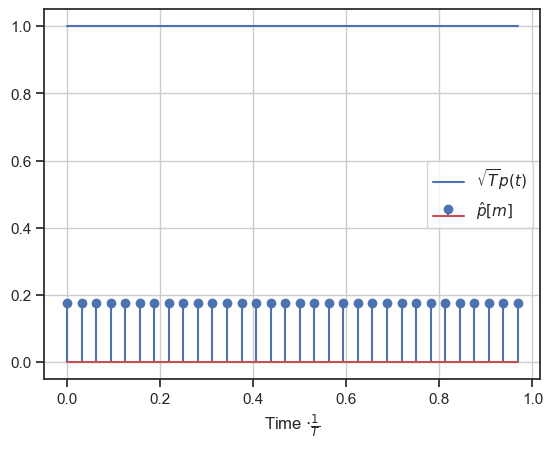

In [4]:
## generate the pulse and plot it
fsT = 32
pp = rect_pulse(fsT)

# plots
tt = np.arange(fsT)/fsT
plt.stem(tt, pp, label=r'$\hat{p}[m]$')
plt.plot(tt, np.sqrt(fsT)*pp, label=r'$\sqrt{T} p(t)$')

plt.grid()
plt.xlabel(r'Time $\cdot \frac{1}{T}$')
plt.legend()

plt.show()

The plot above shows:
* samples of the the unit-energy discrete-time pulse $\hat{p}[m]$ and 
* the continuous-time pulse $p(t)$, scaled by $\sqrt{T}$.
  + plotting the continuous pulse like this, makes it independent of $T$
  + the energy of the scaled pulse is $T$.

### Example: Sine-squared pulse

The function below computes a unit-energy sine-squared pulse with `fsT` samples per symbol period.
 * The resulting samples can be used for pulse-shaping in DSP (see below)

In [5]:
def sine_squared_pulse(fsT):
    """synthesize a sine squared pulse

    Inputs:
    -------
    fsT: samples per symbol period

    Returns:
    --------
    unit-energy pulse of length fsT samples
    """
    nn = np.arange(fsT)
    pp = np.sqrt(8 / (3 * fsT)) * np.sin(np.pi * nn / fsT) ** 2

    return pp

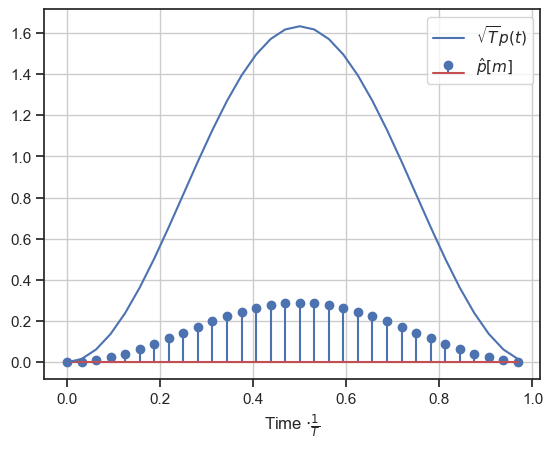

In [6]:
## generate the pulse and plot it
fsT = 32
pp = sine_squared_pulse(fsT)

# plots
tt = np.arange(fsT)/fsT
plt.stem(tt, pp, label=r'$\hat{p}[m]$')
plt.plot(tt, np.sqrt(fsT)*pp, label=r'$\sqrt{T} p(t)$')

plt.grid()
plt.xlabel(r'Time $\cdot \frac{1}{T}$')
plt.legend()

plt.show()

## Pulse Shaping

* We showed above that pulse shaping in discrete-time is described by the following expression
$$
s[m] = \sum_n s_n p[m - n f_sT].
$$
* **Interpretation:** Every $f_sT$ samples, we place a pulse with amplitude $s_n$.
* An alternative, more general, interpretation relies on the convolution operation.
  + Problem: symbol $s_n$ and pulses $p[m]$ are sampled at different rates/
    - symbols are sampled once per symbol period $T$
    - pulses are sampled $fsT$ times per symbol period.
  * Remedy: up-sample the symbol sequence
    - generate a signal $d[m]$ with $f_sT$ samples per symbol period  $T$ by placing $f_sT-1$ zeros between consecutive symbols, i.e.,
    $$
    d[m] = \begin{cases}
    s_n & \text{for $m = n \cdot f_sT$}\\
    0 & \text{else.}
    \end{cases}
    $$
* Then:
$$
s[m] = d[m] \ast p[m] = \sum_k d[k] \cdot p[m - k].
$$
* Note that $d[k] \neq 0$ only if $k = n \cdot f_sT$.

### A function to perform pulse shaping

With the above formulation, we can write a function that performs pulse shaping.
* Inputs:
  - `syms` - a sequence of symbols
  - `pp` - a sampled pulse
  - `fsT` - the oversampling factor
* Steps:
  - up-sample the symbol sequence
    + this produce a length $(L-1) \cdot f_sT + 1$ signal
    + where $L$ is the number of symbols
  - convolve the up-sampled symbols and the pulse

In [7]:
def pulse_shape(syms, pp, fsT):
    """perform pulse shaping for a sequence of symbols

    Inputs:
    -------
    syms: sequence of symbols
    pp: pulse shape (must have `fsT` samples per symbol period)
    fsT: samples per symbol period

    Returns:
    --------
    vector of signal samples; length is equal to (len(syms)-1)*fsT + len(pp)
    """
    # upsample the symbol sequence
    N_dd = (len(syms) - 1) * fsT + 1  # this avoids extra zeros at end
    dd = np.zeros(N_dd, dtype=syms.dtype)
    dd[0::fsT] = syms

    # convolve with pulse
    return np.convolve(dd, pp)

## Example: From information to transmitted signal

The example below shows the process of converting information (the string `Hi`) to bits, then, symbols, and finally (samples) of the transmitted signal.

**Note:** the functions and the dictionary `PAM4` are in the `comms` Python package on Github.

In [8]:
## make some information symbols
bits = string_source('Hi')
print('bits = ', bits)

## modulation mapping - Use 4-PAM to map bits to symbols
symbols = mod_mapper(bits, PAM4)
print('symbols:', symbols.real)

## pulse-shaping: using sine-squared pulses and oversampling fsT=32
fsT = 32
pulse = rect_pulse(fsT)

sig = pulse_shape(symbols, pulse, fsT)


bits =  [0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1]
symbols: [ 3.  1. -1.  1.  3. -1. -1.  3.]


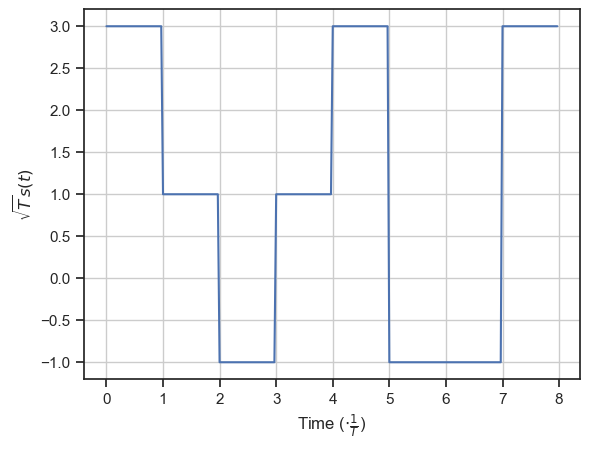

In [9]:
## plot the resulting signals
plt.plot(np.arange(len(sig))/fsT, np.sqrt(fsT)*sig.real)

plt.xlabel(r'Time ($\cdot \frac{1}{T}$)')
plt.ylabel(r'$\sqrt{T} s(t)$')
plt.grid()

plt.show()